In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras import ops

import datasets
datasets.logging.set_verbosity_error()

In [2]:
AVAILABLE_CATEGORIES = [
    'All_Beauty',
    'Arts_Crafts_and_Sewing',
    'Automotive',
    'Baby_Products',
    'Beauty_and_Personal_Care',
    'Books',
    'CDs_and_Vinyl',
    'Cell_Phones_and_Accessories',
    'Clothing_Shoes_and_Jewelry',
    'Electronics',
    'Gift_Cards',
    'Grocery_and_Gourmet_Food',
    'Health_and_Household',
    'Home_and_Kitchen',
    'Industrial_and_Scientific',
    'Kindle_Store',
    'Magazine_Subscriptions',
    'Movies_and_TV',
    'Musical_Instruments',
    'Office_Products',
    'Patio_Lawn_and_Garden',
    'Pet_Supplies',
    'Software',
    'Sports_and_Outdoors',
    'Tools_and_Home_Improvement',
    'Toys_and_Games',
    'Unknown',
    'Video_Games'
]

SELECTED_CATEGORY = 'Musical_Instruments'

# Use 5-core preprocessing to filter out connections with <5 interactions
TRIM_SPARSE_CONNECTIONS = True

dataset = datasets.load_dataset("McAuley-Lab/Amazon-Reviews-2023", ("5core_rating_only_" if TRIM_SPARSE_CONNECTIONS else "0core_timestamp_") + SELECTED_CATEGORY, trust_remote_code=True)
df = dataset['full'].to_pandas()

Musical_Instruments.csv:   0%|          | 0.00/29.7M [00:00<?, ?B/s]

c:\Users\n8tew\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\n8tew\.cache\huggingface\hub\datasets--McAuley-Lab--Amazon-Reviews-2023. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Generating full split: 0 examples [00:00, ? examples/s]

In [3]:
# Creating user and product ID maps
user_ids = df['user_id'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

product_ids = df['parent_asin'].unique().tolist()
product2product_encoded = {x: i for i, x in enumerate(product_ids)}
productencoded2product = {i: x for i, x in enumerate(product_ids)}

df["user"] = df["user_id"].map(user2user_encoded)
df["product"] = df["parent_asin"].map(product2product_encoded)

# Statistical summary of data
num_users = len(user_ids)
num_products = len(product_ids)
num_reviews = len(df)
df["rating"] = df["rating"].values.astype(np.float32)
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Products: {}, Number of Reviews: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_products, num_reviews, min_rating, max_rating
    )
)

print(f'Mean reviews per user: {num_reviews/num_users}')
print(f'Mean reviews per product: {num_reviews/num_products}')

Number of users: 57439, Number of Products: 24587, Number of Reviews: 511836, Min rating: 1.0, Max rating: 5.0
Mean reviews per user: 8.910949006772402
Mean reviews per product: 20.817342498068086


In [4]:
df = df.sample(frac=1, random_state=0)
x = df[["user", "product"]].values

# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [5]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_products, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_products = num_products
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.product_embedding = layers.Embedding(
            num_products,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.product_bias = layers.Embedding(num_products, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        product_vector = self.product_embedding(inputs[:, 1])
        product_bias = self.product_bias(inputs[:, 1])
        dot_user_product = ops.tensordot(user_vector, product_vector, 2)
        # Add all the components (including bias)
        x = dot_user_product + user_bias + product_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return ops.nn.sigmoid(x)


model = RecommenderNet(num_users, num_products, EMBEDDING_SIZE)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

In [6]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
7198/7198 ━━━━━━━━━━━━━━━━━━━━ 136s 19ms/step - loss: 0.5844 - val_loss: 0.4152
Epoch 2/5
7198/7198 ━━━━━━━━━━━━━━━━━━━━ 126s 17ms/step - loss: 0.4122 - val_loss: 0.4494
Epoch 3/5
7198/7198 ━━━━━━━━━━━━━━━━━━━━ 123s 17ms/step - loss: 0.4143 - val_loss: 0.4456
Epoch 4/5
7198/7198 ━━━━━━━━━━━━━━━━━━━━ 124s 17ms/step - loss: 0.4235 - val_loss: 0.4616
Epoch 5/5
7198/7198 ━━━━━━━━━━━━━━━━━━━━ 124s 17ms/step - loss: 0.4442 - val_loss: 0.4513


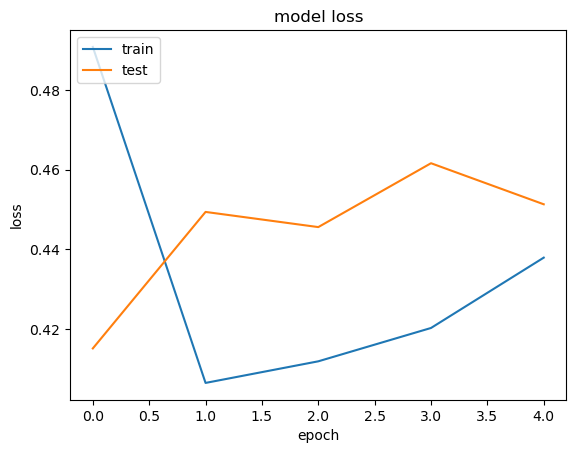

In [7]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [26]:
# Metadata on products. Includes titles, subcategories, etc.
meta = datasets.load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_" + SELECTED_CATEGORY, split="full", trust_remote_code=True)
meta_df = meta.to_pandas()

# Select a random user and find all unseen products
user_id = df.user_id.sample(1).iloc[0]
user_activity = df[df.user_id == user_id]
products_not_reviewed = meta_df[~meta_df['parent_asin'].isin(user_activity.parent_asin.values)]['parent_asin']
products_not_reviewed = list(set(products_not_reviewed).intersection(set(product2product_encoded.keys()))) # Only consider products within our encoding
products_not_reviewed = [[product2product_encoded.get(x)] for x in products_not_reviewed]
user_encoder = user2user_encoded.get(user_id)

# Feed these unseen products into the recommender model and find the highest predicted ratings
user_product_array = np.hstack(
    ([[user_encoder]] * len(products_not_reviewed), products_not_reviewed)
)
ratings = model.predict(user_product_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_product_ids = [productencoded2product.get(products_not_reviewed[x][0]) for x in top_ratings_indices]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Products with high ratings from user")
print("----" * 8)
top_products_user = (
    user_activity.sort_values(by="rating", ascending=False)
    .head(5)
    .parent_asin.values
)
meta_df_rows = meta_df[meta_df["parent_asin"].isin(top_products_user)]
for row in meta_df_rows.itertuples():
    print(row.title)

print("----" * 8)
print("Top 10 product recommendations")
print("----" * 8)
recommended_products = meta_df[meta_df["parent_asin"].isin(recommended_product_ids)]
for row in recommended_products.itertuples():
    print(row.title)

769/769 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step
Showing recommendations for user: AFPPJJ7QKNTD774OBNGBWSGWZ2QQ
Products with high ratings from user
--------------------------------
Shure BETA56A Super Cardioid Swivel-Mount Dynamic Microphone with High Output Neodymium Element for Vocal/Instrument Applications, Gray
Shure Super 55 Deluxe Vocal Microphone - Vintage Supercardioid Dynamic Unidyne Mic, Iconic Look, Classic Sound - Rugged Die-Cast Casing, includes 5/8" to 3/8" Thread Adapter and Zippered, Padded Pouch
Tascam Portacapture X8 High Resolution 32-bit float Multi-Track Recorder, Portable Recorder, Field Recorder, Music, Podcast, Voice, ASMR, Podcasting
LCT 040 Match Small Diaphragm Condenser Microphone
TRITON AUDIO FetHead Phantom In-Line Microphone Preamp
--------------------------------
Top 10 product recommendations
--------------------------------
Shure SM7B Vocal Dynamic Microphone for Broadcast, Podcast & Recording, XLR Studio Mic for Music & Speech, Wide-Range Frequency, Warm &